In [78]:
import torch
from torch import nn
import torch.nn.functional as F
from typing import Callable
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
from torchvision import datasets, transforms
import os
from PIL import Image
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torchvision import models
from torch import nn, optim
from collections import OrderedDict
import csv
import timm

In [27]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torch

class ContestDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            split (string): One of 'train', 'test', 'val' indicating the dataset split.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(self.root_dir) for f in filenames if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg']]
        
        # Extract class names from filenames and assign indices
        self.class_to_idx = {class_name.split('_')[0]: idx for idx, class_name in enumerate(sorted(set(os.path.basename(f).split('_')[0] for f in self.images)))}
        self.idx_to_class = {idx: class_name for class_name, idx in self.class_to_idx.items()}
        self.num_classes = len(self.class_to_idx)
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name).convert('HSV')
        class_name = os.path.basename(img_name).split('_')[0]
        label_idx = self.class_to_idx[class_name]
        label = self.one_hot_encode(label_idx)
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def one_hot_encode(self, label_idx):
        one_hot = torch.zeros(self.num_classes, dtype=torch.float)
        one_hot[label_idx] = 1.0
        return one_hot


In [28]:

class SimpleImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                                             on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root_dir) for f in filenames if f.endswith(('.png', '.jpg', '.jpeg', '.JPEG'))]
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB
        
        if self.transform:
            image = self.transform(image)
        
        # Extract filename from img_path
        filename = os.path.basename(img_path)
        
        return image, filename  # Returns the image and its filename


In [29]:
def rgb_to_hsv(image):
    return image.convert('HSV')

def pil_to_numpy(image):
    return np.array(image)

def numpy_to_tensor(image_array):
    return torch.tensor(image_array).permute(2, 0, 1) / 255.0

In [66]:
# transform_train = transforms.Compose([
#     transforms.Lambda(rgb_to_hsv),  # Convert RGB PIL Image to HSV
#     transforms.Resize(256),         # Resize the image to 256x256 pixels while it's still a PIL Image
#     transforms.CenterCrop(224),     # Crop the center of the image to 224x224 pixels
#     transforms.Lambda(pil_to_numpy),    # Convert HSV PIL Image to numpy array
#     transforms.Lambda(numpy_to_tensor), # Convert numpy array to tensor and normalize
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using the mean and
#                          std=[0.229, 0.224, 0.225])    # std of ImageNet dataset
# ])


# # For validation
# transform_val =transforms.Compose([
#     transforms.Lambda(rgb_to_hsv),  # Convert RGB PIL Image to HSV
#     transforms.Resize(256),         # Resize the image to 256x256 pixels while it's still a PIL Image
#     transforms.CenterCrop(224),     # Crop the center of the image to 224x224 pixels
#     transforms.Lambda(pil_to_numpy),    # Convert HSV PIL Image to numpy array
#     transforms.Lambda(numpy_to_tensor), # Convert numpy array to tensor and normalize
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using the mean and
#                          std=[0.229, 0.224, 0.225])    # std of ImageNet dataset
# ])



transform_train = transforms.Compose([
    transforms.Resize(256),  # Resize to 256x256 pixels
    transforms.RandomCrop(224, 224),  # Crop to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),  # Convert to tensor BEFORE applying tensor transformations
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Apply Gaussian Blur
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),  # Random Erasing
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])




def my_collate_fn(batch):
    max_size = max([img.size() for img, _ in batch])  # Correctly call the size method  
    batch_padded = [(transforms.Pad(padding=(0, 0, max_size[0]-img.size()[0], max_size[1]-img.size()[1]))(img), label) for img, label in batch]
    images = torch.stack([img for img, _ in batch_padded])
    labels = torch.stack([label for _, label in batch])

    return images, labels



# Download and load the training dataset
# trainset = ContestDataset(root_dir
                                #  ="E:\iith-dl-contest-2024", split="train", transform=transform_train)
trainset = datasets.ImageFolder(root='E:/iith-dl-contest-2024/train/train',
                                           transform=transform_train)

print(trainset.class_to_idx)
trainloader = DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=0, collate_fn=None)

# Download and load the test dataset
# testset = ContestDataset(root_dir="E:\iith-dl-contest-2024", split="test", transform=transform_val)
testset = datasets.ImageFolder("C:\\Users\\gupta\\Downloads\\Kaggle-Data-Set\\imagenet\\val\\ILSVRC2012_img_val", transform=transform_val)
testloader = DataLoader(testset, batch_size=2,
                                         shuffle=False, num_workers=0)

csv_dir = 'iith-dl-contest-2024\\test\\test'
csv_dataset = SimpleImageDataset( csv_dir, transform=transform_val)
    
csv_loader = torch.utils.data.DataLoader(
    csv_dataset, batch_size=32, shuffle=False, 
    num_workers=0
)

print(testset.class_to_idx)
print(len(trainloader), len(testloader))

{'n01443537': 0, 'n01774750': 1, 'n01784675': 2, 'n01882714': 3, 'n01910747': 4, 'n01944390': 5, 'n01983481': 6, 'n02056570': 7, 'n02085620': 8, 'n02094433': 9, 'n02099601': 10, 'n02099712': 11, 'n02106662': 12, 'n02190166': 13, 'n02206856': 14, 'n02226429': 15, 'n02233338': 16, 'n02236044': 17, 'n02268443': 18, 'n02279972': 19, 'n02364673': 20, 'n02395406': 21, 'n02410509': 22, 'n02423022': 23, 'n02480495': 24, 'n02481823': 25, 'n02486410': 26, 'n02769748': 27, 'n02793495': 28, 'n02802426': 29, 'n02808440': 30, 'n02814860': 31, 'n02843684': 32, 'n02906734': 33, 'n02948072': 34, 'n02950826': 35, 'n03424325': 36, 'n03649909': 37, 'n04133789': 38, 'n04146614': 39, 'n04275548': 40, 'n04465501': 41, 'n07695742': 42, 'n07720875': 43, 'n07734744': 44, 'n07753592': 45, 'n07768694': 46, 'n07873807': 47, 'n07920052': 48, 'n12267677': 49}
{'n01440764': 0, 'n01443537': 1, 'n01484850': 2, 'n01491361': 3, 'n01494475': 4, 'n01496331': 5, 'n01498041': 6, 'n01514668': 7, 'n01514859': 8, 'n01518878': 9

tensor([13, 26, 28,  0, 19, 45,  5, 36, 30, 24, 47,  9,  8,  8, 13, 49, 15, 34,
        15, 44, 47, 17, 45, 42, 40,  7, 17, 28, 47, 10,  5, 18])


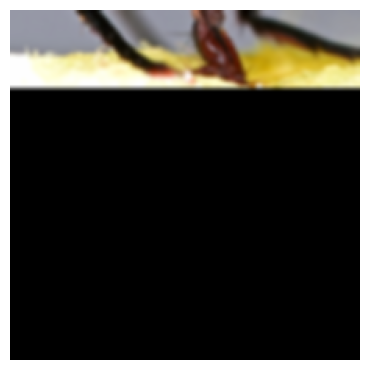

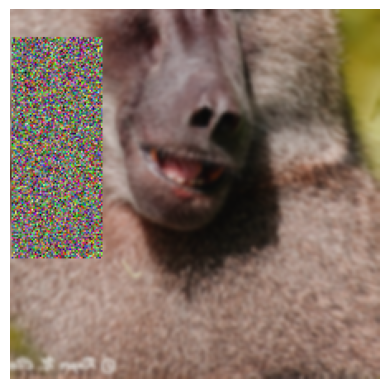

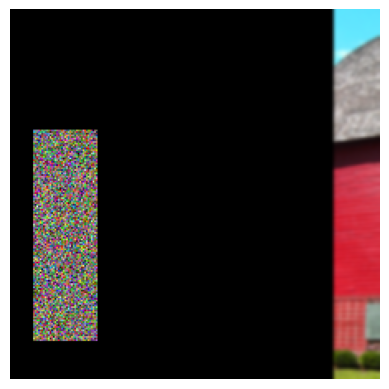

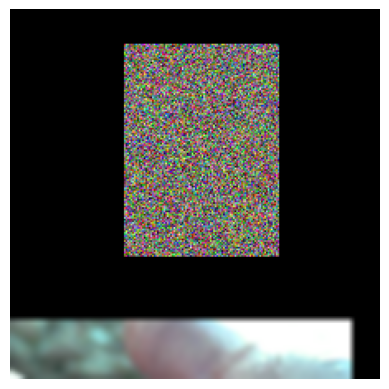

In [57]:
def imshow(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')  # Don't show axes for images
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)  # Get one batch of images and labels

print(labels)

# Display 4 images
fig = plt.figure(figsize=(10, 10))
for idx in np.arange(4):
    ax = fig.add_subplot(2, 2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


# Model

In [32]:
def similarity_fun(Q: torch.tensor, K: torch.tensor):
    return torch.bmm(Q, K.transpose(1, 2))/torch.sqrt(torch.tensor(K.shape[-1]))

In [33]:
# input shape [batch_size, channel, width, hieght]
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_planes, out_planes, head, similarity_fun: Callable[[torch.tensor], torch.tensor]) -> None:
        super().__init__()
        self.qurey = nn.Conv2d(in_planes, out_planes, kernel_size=1)
        self.key = nn.Conv2d(in_planes, out_planes, kernel_size=1)
        self.value = nn.Conv2d(in_planes, out_planes, kernel_size=1)
        self.similarity_fun = similarity_fun
        self.output = nn.Conv2d(out_planes, in_planes, kernel_size=1)
        self.gamma = nn.Parameter(torch.tensor([0.]))
        self.head = head
        self.out_dim = out_planes // self.head
    
    def forward(self, x):
        shape = x.shape
        batch_size, channels, width, height = shape
        # print("x", x.shape)
        q, k, v = self.qurey(x), self.key(x), self.value(x)        
        #For single head
        # q = q.view(*q.shape[:2], -1)
        # k = k.view(*k.shape[:2], -1)
        # v = v.view(*v.shape[:2], -1)

        #For multi head
        q = q.view(batch_size * self.head, self.out_dim, width * height)
        k = k.view(batch_size * self.head, self.out_dim, width * height)
        v = v.view(batch_size * self.head, self.out_dim, width * height)

        
        a = F.softmax(self.similarity_fun(q, k), dim=-1)

        # print('a', a.shape)
        # print('v', v.shape)
        channels = v.shape[1]
        #For single head
        # o = self.output(torch.bmm(a, v).view(batch_size, channels, width, height))
        #For multi head
        o = self.output(torch.bmm(a, v).view(batch_size, self.out_dim * self.head, width, height))
        # print('val',  o.shape)

        return self.gamma * o + x 


In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    

In [35]:
class CNNWithAttention(nn.Module):
    def __init__(self):
        super(CNNWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = ResidualBlock(16, 32, stride=2)
        self.att1 = SelfAttentionLayer(32, 64, 4, similarity_fun)  # Adjust parameters as necessary
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.att2 = SelfAttentionLayer(64, 128, 4, similarity_fun)  # Adjust parameters as necessary
        self.layer3 = ResidualBlock(64, 128, stride=2)
        self.gpa = nn.AdaptiveAvgPool2d((1, 1))
        self.finalFC = nn.Linear(128, 50)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.att1(x)  
        x = self.layer2(x)
        x = self.att2(x)  
        x = self.layer3(x)
        x = self.gpa(x)
        x = x.view(x.size(0), -1)
        x = self.finalFC(x)
        return x

In [36]:
class CNN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.convSelf1 = SelfAttentionLayer(16, 32, 4, similarity_fun)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.gpa = nn.AdaptiveAvgPool2d((1, 1))
        self.finalFC = nn.Linear(64, 50)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.convSelf1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.gpa(x)
        x = x.view(-1, 64)
        return self.finalFC(x)

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class BottleneckResidualBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        bottleneck_channels = out_channels // self.expansion

        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)
        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CNNWithAttentionAndBottlenecks(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 256, blocks=3, stride=1)
        self.layer2 = self._make_layer(256, 512, blocks=4, stride=2)
        self.attention1 = TransformerEncoderLayer(d_model=512, nhead=8)
        self.layer3 = self._make_layer(512, 1024, blocks=6, stride=2)
        self.attention2 = TransformerEncoderLayer(d_model=1024, nhead=8)
        self.layer4 = self._make_layer(1024, 2048, blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [BottleneckResidualBlock(in_channels, out_channels, stride=stride)]
        for _ in range(1, blocks):
            layers.append(BottleneckResidualBlock(out_channels * BottleneckResidualBlock.expansion, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = x.permute(2, 3, 0, 1)  # Transformer expects [S, N, E] format
        x = self.attention1(x)
        x = x.permute(2, 3, 0, 1)  # Convert back to [N, C, H, W] format

        x = self.layer3(x)
        x = x.permute(2, 3, 0, 1)  # Transformer expects [S, N, E] format
        x = self.attention2(x)
        x = x.permute(2, 3, 0, 1)  # Convert back to [N, C, H, W] format

        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [38]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # [B, E, H/P, W/P]
        x = x.flatten(2)  # [B, E, N]
        x = x.transpose(1, 2)  # [B, N, E]
        return x

class ViTForImageClassification(nn.Module):
    def __init__(self, num_classes=50, img_size=224, patch_size=16, emb_size=768, depth=12, heads=12, mlp_ratio=4.0):
        super().__init__()
        self.patch_embedding = PatchEmbedding(patch_size=patch_size, emb_size=emb_size, img_size=img_size)
        num_patches = (img_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        self.positional_embedding = nn.Parameter(torch.zeros(1, 1 + num_patches, emb_size))
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=emb_size, nhead=heads, dim_feedforward=int(emb_size * mlp_ratio)), num_layers=depth)
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes)
        )

    def forward(self, x):
        x = self.patch_embedding(x)
        b, n, _ = x.shape
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.positional_embedding[:, :(n + 1)]
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)


In [39]:
import torch
import torch.nn as  nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)


In [84]:
class EnsembleModel(nn.Module):
    def __init__(self, models_ensemble, num_classes, device):
        super(EnsembleModel, self).__init__()
        self.models_ensemble = {name: model.to(device) for name, model in models_ensemble.items()}
        self.num_classes = num_classes
        self.device = device

    def forward(self, x):
        # Aggregate the predictions of the models
        x = x.to(self.device)  # Ensure input is on the correct device
        outputs = torch.stack([model(x) for model in self.models_ensemble.values()])
        avg = outputs.mean(0)
        return avg


# Instantiate the models and update the classifiers
models_ensemble = {
    'efficientnet_b0': models.efficientnet_b0(pretrained=False),
    'resnet50': models.resnet50(pretrained=False),
    'densenet121': models.densenet121(pretrained=False),
    'vit_b_16': timm.create_model('vit_base_patch16_224', pretrained=False),
}

num_classes = 1000  # Number of classes in ImageNet

# Adjust each model to output the correct number of classes
models_ensemble['efficientnet_b0'].classifier[1] = nn.Linear(models_ensemble['efficientnet_b0'].classifier[1].in_features, num_classes)
models_ensemble['resnet50'].fc = nn.Linear(models_ensemble['resnet50'].fc.in_features, num_classes)
models_ensemble['densenet121'].classifier = nn.Linear(models_ensemble['densenet121'].classifier.in_features, num_classes)
if hasattr(models_ensemble['vit_b_16'], 'classifier'):
    models_ensemble['vit_b_16'].classifier = nn.Linear(models_ensemble['vit_b_16'].classifier.in_features, num_classes)
else:
    models_ensemble['vit_b_16'].head = nn.Linear(models_ensemble['vit_b_16'].head.in_features, num_classes)




c:\Users\gupta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gupta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\gupta\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get t

# Training

In [85]:
# Define a ResNet-18 model
# model = models.resnet18(weights=None)  # Do not load pre-trained weights
# model.fc = nn.Linear(model.fc.in_features, 50)  # Adjusting for ImageNet's 1000 classes

# model = models.vit_l_32 (weights=True)  # Do not load pre-trained weights
# model.fc = nn.Linear(model.fc.in_features, 50)  # Adjusting for ImageNet's 1000 classes
# Create the ensemble model

# model = CNN()
# model = CNNWithAttention()
# model = CNNWithAttentionAndBottlenecks()
# model = ViTForImageClassification()
# model = ResNet50(50)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make model DataParallel to run on multiple GPUs
if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = EnsembleModel(models_ensemble, num_classes=num_classes, device=device)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# Optionally, adjust the learning rate with a scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
print(device)


cuda


In [17]:
import os

def save_checkpoint(state, filename="model_checkpoint.tar"):
    os.makedirs(os.path.dirname(filename), exist_ok=True)  # Ensure directory exists
    torch.save(state, filename)

def load_checkpoint(checkpoint_path, model, optimizer, scheduler=None, main=False, resume=None):
    checkpoint = torch.load(checkpoint_path)
    if main:
        # Load the checkpoint

        new_state_dict = OrderedDict()

        # Remove 'module.' prefix
        for k, v in checkpoint['state_dict'].items():
            name = k[7:] if k.startswith('module.') else k  # remove `module.` prefix
            new_state_dict[name] = v


        model.load_state_dict(new_state_dict)

        
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        print("=> loaded checkpoint '{}' (epoch {})"
            .format(resume, checkpoint['epoch']))        
    else:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler is not None and 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        return checkpoint.get('epoch', -1), checkpoint.get('best_accuracy', 0.0)

def train_and_validate(model, train_loader, test_loader, optimizer, criterion, device, scheduler=None, num_epochs=5, checkpoint_path=None, filename="checkpoints/model_checkpoint.tar"):
    start_epoch = 0
    best_accuracy = 0.0
    # Initialize lists to store per-epoch accuracies
    val_accuracies = []
    tra_loss = []
    val_loss = []
    flag = checkpoint_path is not None and checkpoint_path != filename

    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        start_epoch, best_accuracy = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
        print(f"Loaded checkpoint '{checkpoint_path}' (epoch {start_epoch}), best accuracy: {best_accuracy}%")
        start_epoch += 1  # Continue from next epoch

    for epoch in range(start_epoch, start_epoch + num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{start_epoch + num_epochs}', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs + start_epoch}], Loss: {running_loss/len(train_loader):.4f}')
        tra_loss.append((epoch+1, running_loss/len(train_loader)))
        # Update the learning rate scheduler after each epoch
        if scheduler is not None:
            scheduler.step()

        # Validation loop
        model.eval()
        total = 0
        correct = 0
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc='Validating', leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()
        
        current_accuracy = 100 * correct / total
        print(f'Validation Accuracy: {current_accuracy:.2f}%')
        val_accuracies.append((epoch+1,current_accuracy))
        val_loss.append((epoch+1, running_loss/len(test_loader)))
        
        # Save checkpoint if current accuracy is the best
        if current_accuracy > best_accuracy or flag:
            print("Saving new best model")
            best_accuracy = current_accuracy
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_accuracy': best_accuracy
            }
            if scheduler is not None:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()
            save_checkpoint(checkpoint, filename=filename)
            flag = False

    return val_accuracies, tra_loss, val_loss


In [105]:
# filepath = "checkpoints/custom/model_cnnWithAttention_adam_lr_0001_scheduler_stepLr_step_30_gamma_01.tar"
filepath_base = "checkpoints\\resnet\\model_resent50_sgd_lr_01_momentum_09_wieghtDecay_00001_scheduler_stepLr_data_rgb.tar"
filepath_new = "checkpoints\\resnet\\preTrain_model_resent50_sgd_lr_01_momentum_09_wieghtDecay_00001_scheduler_stepLr_data_rgb_randomCrop_randomErasing.tar"
# filepath = "checkpoints\\main\\resent\\best_default.pth.tar"

In [107]:
filename = filepath_new.split("\\")[-1]  # This splits the path by the backslash and takes the last part

# Now, remove the file extension
predfilename = filename.rsplit('.', 1)[0]  # This splits the filename by the last dot and takes the first part

vit_val_acc, vit_tra_loss, vit_val_loss = train_and_validate(model, trainloader, testloader, optimizer, criterion, device, scheduler, num_epochs=20, checkpoint_path=filepath_base, filename=filepath_new)

Loaded checkpoint 'checkpoints\resnet\model_resent50_sgd_lr_01_momentum_09_wieghtDecay_00001_scheduler_stepLr_data_rgb.tar' (epoch 32), best accuracy: 79.64%


Epoch [34/53], Loss: 2.8063


Validation Accuracy: 71.04%
Saving new best model


Epoch [35/53], Loss: 2.6143


Validation Accuracy: 72.60%
Saving new best model


Epoch [36/53], Loss: 2.5547


Validation Accuracy: 67.88%


Epoch [37/53], Loss: 2.5108


Validation Accuracy: 72.20%


Epoch [38/53], Loss: 2.4900


Validation Accuracy: 69.44%


Epoch [39/53], Loss: 2.4548


Validation Accuracy: 70.56%


Epoch 40/53:   4%|▍         | 84/2032 [00:42<17:17,  1.88it/s]

In [18]:
import torch
from tqdm import tqdm

def validate_model(model, test_loader, criterion, device):
    """
    Performs validation on a given dataset using the provided model.

    Parameters:
    - model: The neural network model to be evaluated.
    - test_loader: DataLoader for the test dataset.
    - criterion: The loss function.
    - device: The device (CPU/GPU) on which to perform the validation.

    Returns:
    - current_accuracy: The accuracy of the model on the test dataset.
    - average_loss: The average loss of the model on the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    running_loss = 0.0
    
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels in tqdm(test_loader, desc='Validating', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    
    current_accuracy = 100 * correct / total
    average_loss = running_loss / len(test_loader)
    
    print(f'Validation Accuracy: {current_accuracy:.2f}%')
    print(f'Average Validation Loss: {average_loss:.4f}')
    
    return current_accuracy, average_loss


In [86]:
# load_checkpoint(filepath, model, optimizer,scheduler=scheduler, main=True, resume='checkpoints\\main\\resent\\best_default.pth.tar')
# load_checkpoint(filepath, model, optimizer, scheduler)
validate_model(model, testloader, criterion, device)

Validation Accuracy: 0.10%
Average Validation Loss: 6.9368


(0.096, 6.93680472946167)

In [60]:
# Function to output predictions to CSV
def output_csv_test(val_loader, model, train_dataset, output_csv_path='predictions.csv'):
    model.eval()  # Set the model to evaluation mode
    
    # Move model to GPU if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Invert the class_to_idx dictionary to get a mapping from index to class name
    idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
    
    with torch.no_grad(), open(output_csv_path, 'w', newline='') as csvfile:
        fieldnames = ['ID', 'Category']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        for i, (images, filenames) in enumerate(val_loader):
            images = images.to(device)  # Move input tensors to the same device as the model
            outputs = model(images)  # Get predictions from the model
            
            _, predicted_indices = torch.max(outputs, 1)
            predicted_classnames = [idx_to_class[idx.item()] for idx in predicted_indices.cpu()]
            
            # Write to CSV file using filenames and predicted class names
            for filename, classname in zip(filenames, predicted_classnames):
                writer.writerow({'ID': filename, 'Category': classname})


In [76]:
import os

# Your existing path manipulation
filepath = "pretrained_prediction/ensemble_efficientnetB0_resnet50_densenet121_vitB16/"
filename = os.path.basename(os.path.normpath(filepath))
predfilename = filename.split('.')[0] if '.' in filename else filename
checkpoint_dir = os.path.dirname(filepath)
csv_filename = os.path.join(checkpoint_dir, 'pretrained_predictions_' + predfilename + '.csv')

# Ensure the directory exists
os.makedirs(checkpoint_dir, exist_ok=True)  # Creates the directory if it does not exist

# Assuming output_csv_test is a defined function elsewhere
try:
    output_csv_test(csv_loader, model, testset, csv_filename)
    print("File is created:", csv_filename)
except FileNotFoundError as e:
    print("Failed to create file:", e)


File is created: pretrained_prediction/vit_l_32\pretrained_predictions_vit_l_32.csv
